# Tabla de contenido

1. [Introducción](#intro)
2. [Modelo de detección de spam](#modelo)
   1. [Descripción del modelo usado en la app](#modelo1)
   2. [Ejemplo básico de inferencia](#modelo2)
3. [Análisis Exploratorio de Datos (EDA)](#eda)
   1. [Carga y descripción general del dataset](#eda1)
   2. [Distribución de clases (desbalance ham vs spam)](#eda2)
   3. [Análisis de longitud de los mensajes](#eda3)
   4. [Palabras más frecuentes por clase](#eda4)
   5. [Embeddings y PCA para visualización](#eda5)
4. [Evaluación del modelo en el dataset completo](#eval)
5. [Conclusiones](#con)


<a id="intro"></a>
## 1. Introducción

El presente notebook tiene como objetivo documentar de manera detallada la metodología de ciencia de datos aplicada para el problema de detección de mensajes SMS de spam. A lo largo del notebook se describe, paso a paso, el proceso seguido, incluyendo tanto la justificación conceptual como la implementación práctica mediante código en Python.

En primer lugar, se presenta el **modelo de clasificación de texto** utilizado en la aplicación (`Goodmotion/spam-mail-classifier`), explicando su funcionamiento a alto nivel, el tipo de salida que genera y cómo se integra en la clase `SpamDetector` para predecir si un mensaje es spam o no. Se ilustra su uso con ejemplos básicos de inferencia para mostrar cómo interpretar las predicciones y los niveles de confianza asociados.

Posteriormente, se realiza un **Análisis Exploratorio de Datos (EDA)** sobre el dataset `SMSSpamCollection`, donde se describen las variables disponibles, la distribución de las clases (ham vs spam) y el desbalance existente. Se analizan características como la longitud de los mensajes, la frecuencia de palabras y se emplean técnicas de representación numérica (embeddings) junto con **PCA** para visualizar la separación entre mensajes spam y no spam en un espacio de menor dimensión.

Finalmente, se evalúa el desempeño del modelo utilizado en la app sobre el conjunto completo de datos. Para ello, se generan las predicciones del modelo y se calculan diversas **métricas de desempeño** (accuracy, precision, recall, F1-score, matriz de confusión y, cuando es posible, ROC-AUC). Estas métricas permiten cuantificar qué tan bien el modelo distingue entre mensajes spam y ham, así como analizar los tipos de errores más frecuentes.

En conjunto, este notebook cumple con el propósito de documentar la metodología de ciencia de datos aplicada, mostrando de forma transparente el flujo completo: desde la comprensión del problema y análisis de los datos, hasta la aplicación del modelo y la evaluación cuantitativa de sus resultados, todo ello acompañado del código correspondiente.

<a id="modelo"></a>
## 2. Modelo de detección de spam

En un problema de clasificación de texto como la detección de spam, existen varias maneras de abordar la etapa de modelado. Una de ellas consiste en generar y entrenar un modelo propio desde cero (o ajustando un modelo base), lo que implica definir la arquitectura, dividir el dataset en conjuntos de entrenamiento, validación y prueba, entrenar el modelo, ajustar hiperparámetros y, finalmente, seleccionar y evaluar la mejor alternativa. Este enfoque pone el foco en todo el proceso de entrenamiento, validación y búsqueda del modelo más adecuado.

Otra opción es utilizar directamente un modelo preentrenado que ya se encuentre disponible para su uso. En este caso, el trabajo se centra principalmente en integrarlo en la aplicación, adaptar el formato de entrada y salida de los datos, y evaluar su comportamiento sobre el dataset específico del problema. Es decir, el énfasis está más en la utilización práctica del modelo que en su entrenamiento desde cero.

En este proyecto hemos elegido la segunda opción: usar un modelo preentrenado (`Goodmotion/spam-mail-classifier`) en lugar de desarrollar y entrenar uno propio. La razón principal es que el objetivo del proceso **no es la modelación en sí**, sino la construcción de una **aplicación funcional** que permita clasificar de forma confiable un correo o mensaje como **spam** o **ham (no spam)**.

Este enfoque nos permite concentrarnos en aspectos como:

- La integración del modelo dentro de la clase `SpamDetector` y de la app.
- El flujo de datos desde que el usuario introduce un mensaje hasta que recibe la predicción.
- La validación de que la aplicación cumple su propósito de clasificar correctamente los mensajes.

Aun así, en el notebook se documenta el análisis de los datos y la evaluación del modelo sobre el dataset, con el fin de comprobar que la solución elegida ofrece un desempeño adecuado para el problema planteado.

<a id="modelo1"></a>
### 2.1 Descripción del modelo usado en la app

Para resolver el problema de detección de spam, en esta aplicación utilizamos un **modelo de clasificación de texto preentrenado**. Es decir, no partimos de un modelo vacío que se entrena desde cero, sino de un modelo que ya fue entrenado previamente sobre un gran conjunto de datos y que está disponible para su uso directo a través de una librería.

En términos generales, este modelo recibe como entrada un **texto en lenguaje natural** (por ejemplo, el contenido de un mensaje SMS o un correo electrónico) y devuelve como salida una **probabilidad asociada a cada clase** de interés, en nuestro caso:

- `ham` (no spam)
- `spam` (mensaje no deseado)

El flujo interno del modelo puede resumirse en los siguientes pasos:

- **Tokenización del texto**:  
  El texto plano se convierte en una secuencia de tokens (unidades más pequeñas, como palabras o subpalabras). Esta tokenización también se mapea a identificadores numéricos que el modelo puede procesar.

- **Cálculo de representaciones (embeddings)**:  
  Cada token se transforma en un vector numérico (embedding) que captura información semántica y contextual del texto.

- **Procesamiento con capas de Transformer**:  
  La secuencia de embeddings se pasa por varias capas del modelo (basadas en la arquitectura Transformer), que permiten que cada palabra “atienda” al contexto completo del mensaje. Esto ayuda a capturar relaciones complejas, como la presencia de palabras que suelen aparecer en mensajes fraudulentos, ofertas engañosas, urgencias sospechosas, etc.

- **Capa de clasificación**:  
  A partir de la representación final del mensaje, una capa lineal (o “cabeza de clasificación”) genera puntuaciones (“logits”) para cada clase. Luego, se aplica una función *softmax* para convertir esas puntuaciones en **probabilidades**.

- **Salida final**:  
  El modelo devuelve:
  - La **clase predicha** (spam o ham).
  - Una **probabilidad/confianza** asociada a esa predicción.

En la app, este modelo se integra dentro de una capa de abstracción (por ejemplo, una clase como `SpamDetector`) que se encarga de:

- Recibir el texto desde la interfaz de usuario (mensaje o correo).
- Llamar internamente al modelo de clasificación de texto.
- Mapear la salida del modelo a etiquetas más amigables (`"SPAM"` / `"HAM"` o valores booleanos).
- Devolver al resto de la aplicación tanto la decisión final (spam / ham) como el nivel de confianza.

Gracias a esta integración, desde el punto de vista de la app el uso del modelo es muy sencillo: solo se necesita pasarle el texto y recibir la clasificación, sin preocuparse por los detalles internos de tokenización, embeddings o arquitectura del Transformer. Esto nos permite centrarnos en el objetivo principal del proyecto: **construir una aplicación funcional** que, de manera rápida y confiable, determine si un mensaje debe ser considerado spam o no.



<a id="modelo2"></a>
### 2.2 Ejemplo básico de inferencia


La app utiliza el modelo de Hugging Face:

- **Nombre del modelo**: `Goodmotion/spam-mail-classifier`
- **Tipo de tarea**: `text-classification`
- **Clases**: `SPAM` y `NOSPAM`
- **Base model**: `microsoft/Multilingual-MiniLM-L12-H384` (un modelo Multilingual MiniLM)

En el código de la app existe la clase `SpamDetector`, que hace lo siguiente:

```python
from transformers import pipeline

class SpamDetector:
    def __init__(self, model_name: str = "Goodmotion/spam-mail-classifier"):
        self.pipe = pipeline("text-classification", model=model_name)
        self.label_map = {"LABEL_0": False, "LABEL_1": True}

    def is_spam(self, text: str) -> tuple[bool, int]:
        result = self.pipe(text)[0]
        return self.label_map[result["label"]], result["score"]


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# Add the project root to the Python path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [9]:
from app.services.spam_detector import SpamDetector

# Instanciar el detector tal como en la app
detector = SpamDetector()

# Ejemplo de texto
ejemplos = [
    "Congratulations! You've won a free lottery ticket. Click here to claim your prize.",
    "Hola, ¿vamos a almorzar hoy a las 12?",
    "URGENTE: Actualiza tu información bancaria para evitar el bloqueo de tu cuenta."
]

for texto in ejemplos:
    es_spam, score = detector.is_spam(texto)
    print(f"Texto: {texto}")
    print(f"¿Es spam?: {es_spam} (confianza = {score:.4f})")
    print("-" * 80)

c:\Users\xxraz\OneDrive\Documentos\Desarrollo\maestria\HIA\spam-detection-web\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu
Device set to use cpu


Texto: Congratulations! You've won a free lottery ticket. Click here to claim your prize.
¿Es spam?: True (confianza = 0.9992)
--------------------------------------------------------------------------------
Texto: Hola, ¿vamos a almorzar hoy a las 12?
¿Es spam?: False (confianza = 0.9991)
--------------------------------------------------------------------------------
Texto: URGENTE: Actualiza tu información bancaria para evitar el bloqueo de tu cuenta.
¿Es spam?: True (confianza = 0.9991)
--------------------------------------------------------------------------------


<a id="eda"></a>
## 3. Análisis exploratorio de datos

 <a id="eda1"></a>
### 3.1 Carga y descripción general del dataset
 
 
 

In [12]:
DATA_PATH = '../data/SMSSpamCollection.txt'

df = pd.read_csv(DATA_PATH, sep="\t", header=None, names=["label", "text"])
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [14]:
df.describe(include="all")

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


#### Resumen del dataset

- Cada fila es un SMS.
- La columna `label` indica si es **`ham`** (no spam) o **`spam`**.
- La columna `text` contiene el contenido del mensaje.

En este dataset hay:

- ✅ 5572 mensajes en total.
- ✅ 4825 `ham` (~86.6%)
- ✅ 747 `spam` (~13.4%)

Es decir, hay un **desbalance importante de clases**: la mayoría de los mensajes son `ham`.


 <a id="eda2"></a>
### 3.2 Distribución de clases (desbalance ham vs spam)
 
 
   

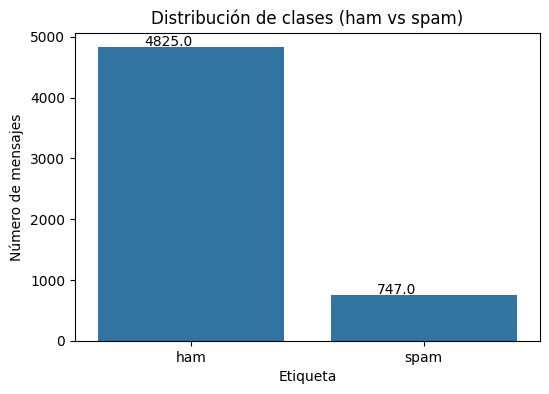

label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

In [15]:
plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x="label")
plt.title("Distribución de clases (ham vs spam)")
plt.xlabel("Etiqueta")
plt.ylabel("Número de mensajes")

for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + 0.2, p.get_height() + 20))

plt.show()

df["label"].value_counts(normalize=True).rename("proportion")


 <a id="eda3"></a>
### 3.3 Análisis de longitud de los mensajes



 


In [16]:
df["n_chars"] = df["text"].str.len()
df["n_words"] = df["text"].str.split().str.len()

df[["n_chars", "n_words"]].describe()

,n_chars,n_words
count,5572.000000,5572.000000
mean,80.489950,15.597452
std,59.942907,11.404053
min,2.000000,1.000000
25%,36.000000,7.000000
50%,62.000000,12.000000
75%,122.000000,23.000000
max,910.000000,171.000000


In [17]:
df.groupby("label")[["n_chars", "n_words"]].mean()

,n_chars,n_words
label,,
ham,71.482487,14.310259
spam,138.670683,23.911647


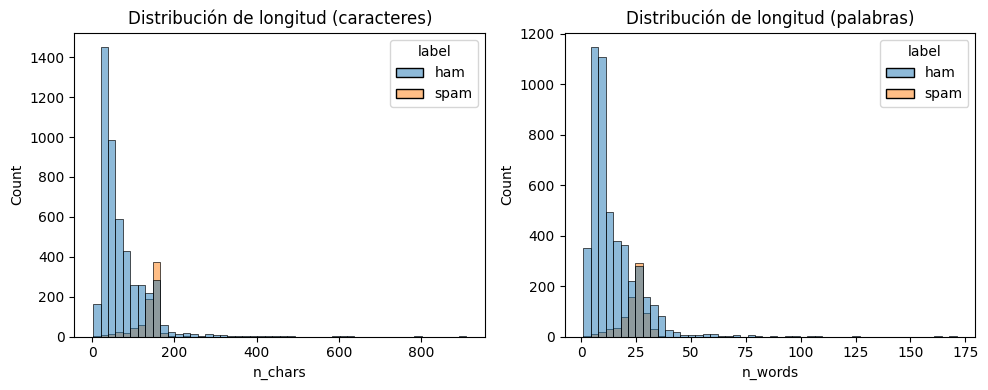

In [18]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.histplot(data=df, x="n_chars", hue="label", bins=50, kde=False)
plt.title("Distribución de longitud (caracteres)")

plt.subplot(1,2,2)
sns.histplot(data=df, x="n_words", hue="label", bins=50, kde=False)
plt.title("Distribución de longitud (palabras)")

plt.tight_layout()
plt.show()


 <a id="eda4"></a>
### 3.4 Palabras más frecuentes por clase






In [19]:
from collections import Counter
import re

def limpiar_texto(t):
    t = t.lower()
    t = re.sub(r"[^a-z0-9áéíóúüñç ]", " ", t)
    return t

df["clean_text"] = df["text"].apply(limpiar_texto)

def top_n_words(series, n=20):
    counter = Counter()
    for text in series:
        counter.update(text.split())
    return pd.DataFrame(counter.most_common(n), columns=["word", "count"])

top_ham = top_n_words(df.loc[df["label"]=="ham", "clean_text"], 20)
top_spam = top_n_words(df.loc[df["label"]=="spam", "clean_text"], 20)

top_spam.head()


,word,count
0,to,691
1,a,380
2,call,355
3,you,297
4,your,264


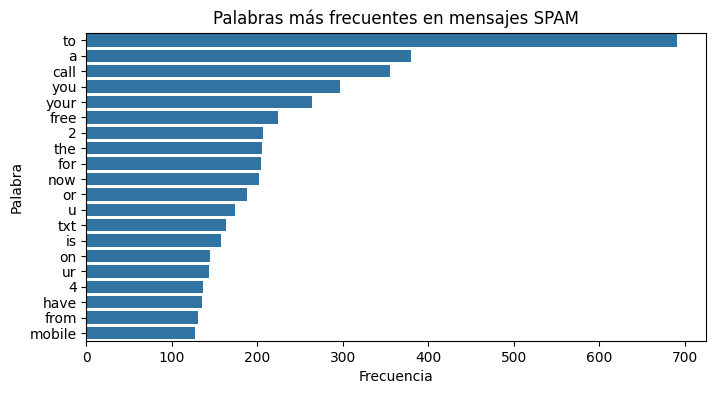

In [20]:
plt.figure(figsize=(8,4))
sns.barplot(data=top_spam, x="count", y="word")
plt.title("Palabras más frecuentes en mensajes SPAM")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.show()

 <a id="eda5"></a>
### 3.5 Embeddings y PCA para visualización





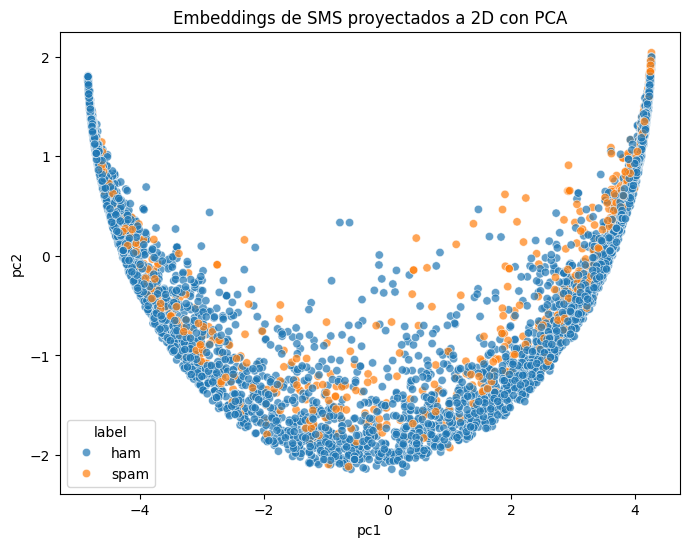

In [22]:
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
import torch

MODEL_NAME = "Goodmotion/spam-mail-classifier"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
base_model = AutoModel.from_pretrained(MODEL_NAME)

def compute_embeddings(texts, batch_size=32, max_length=128):
    all_embeddings = []
    base_model.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            encoded = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )
            outputs = base_model(**encoded)
            # Promediamos las representaciones de los tokens → embedding por frase
            emb = outputs.last_hidden_state.mean(dim=1)  # (batch, hidden_dim)
            all_embeddings.append(emb.cpu())
    return torch.cat(all_embeddings, dim=0).numpy()

# Tomamos una muestra para que sea rápido
sample = df#.sample(n=1000, random_state=42)
embeddings = compute_embeddings(sample["text"].tolist())

pca = PCA(n_components=2)
coords = pca.fit_transform(embeddings)

sample["pc1"] = coords[:, 0]
sample["pc2"] = coords[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=sample,
    x="pc1",
    y="pc2",
    hue="label",
    alpha=0.7
)
plt.title("Embeddings de SMS proyectados a 2D con PCA")
plt.show()


#### Interpretación del gráfico de embeddings + PCA

En la figura se muestran los **embeddings de cada SMS** proyectados a dos dimensiones mediante **PCA**.  
Cada punto representa un mensaje:

- El eje **pc1** (horizontal) y el eje **pc2** (vertical) son las dos primeras componentes principales, es decir, las direcciones que explican la mayor parte de la variabilidad de los embeddings en el espacio original de alta dimensión.
- Los puntos están coloreados según la etiqueta real del mensaje:
  - Azul: mensajes **ham** (no spam).
  - Naranja: mensajes **spam**.

Se observa una forma en “U” o parábola invertida. Esto no tiene un significado “geométrico” directo en el mundo real, sino que es el resultado de cómo PCA comprime a 2D una estructura que originalmente es mucho más compleja y de mayor dimensión. La curvatura indica que los embeddings de los mensajes parecen estar organizados sobre una especie de **manifold no lineal**, que PCA intenta aplanar en un plano.

En cuanto a la **separación entre clases**, se aprecia que:

- Los puntos de spam (naranja) no forman un clúster completamente separado; están bastante mezclados con los mensajes ham.
- Aun así, hay zonas donde la densidad de puntos spam es algo mayor (por ejemplo, en ciertas regiones del arco), lo que sugiere que en el espacio de embeddings sí existen **regiones con mayor probabilidad de ser spam**, aunque la separación no es perfecta en solo dos componentes.

Es importante remarcar que:

- PCA es una técnica **no supervisada**: no utiliza las etiquetas (spam/ham) para encontrar estas direcciones, solo se guía por la variabilidad de los datos.
- Aquí solo estamos viendo **2 dimensiones** de un espacio mucho más grande. El modelo de clasificación original trabaja en todo el espacio de embedding, donde puede existir una separación más clara entre spam y ham que la que se aprecia en este gráfico 2D.

En resumen, el gráfico muestra que los embeddings capturan cierta estructura que ayuda a distinguir mensajes spam de ham, pero la separación visual en 2D no es perfecta. Esto es esperable y refuerza la idea de que el modelo necesita una capa de clasificación adicional que aproveche toda la información del espacio de alta dimensión para tomar decisiones más precisas.








 <a id="eval"></a>
## 4. Evaluación del modelo en el dataset completo

In [23]:
# Etiqueta binaria: 1 = spam, 0 = ham
y_true = (df["label"] == "spam").astype(int).values

In [24]:
from app.services.spam_detector import SpamDetector

detector = SpamDetector()
clf_pipe = detector.pipe  # transformers pipeline

def predict_dataset(texts, batch_size=32):
    y_pred = []
    y_score = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size].tolist()
        results = clf_pipe(batch, truncation=True)
        for r in results:
            label = r["label"]        # "LABEL_0" o "LABEL_1"
            score = r["score"]        # probabilidad de la clase predicha

            # La clase 1 corresponde a SPAM (LABEL_1 → True en SpamDetector)
            pred = 1 if label == "LABEL_1" else 0

            y_pred.append(pred)
            # Opcional: guardamos score como prob. de ser SPAM; si el modelo siempre da
            # score de la clase predicha, podemos usar score si pred==1, 1-score si pred==0
            if pred == 1:
                y_score.append(score)
            else:
                y_score.append(1 - score)
    return np.array(y_pred), np.array(y_score)

y_pred, y_score = predict_dataset(df["text"])


Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [25]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
)

acc = accuracy_score(y_true, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average="binary", pos_label=1
)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

print("\nReporte de clasificación:\n")
print(classification_report(y_true, y_pred, target_names=["ham", "spam"]))


Accuracy:  0.4411
Precision: 0.1596
Recall:    0.7430
F1-score:  0.2628

Reporte de clasificación:

              precision    recall  f1-score   support

         ham       0.91      0.39      0.55      4825
        spam       0.16      0.74      0.26       747

    accuracy                           0.44      5572
   macro avg       0.53      0.57      0.41      5572
weighted avg       0.81      0.44      0.51      5572



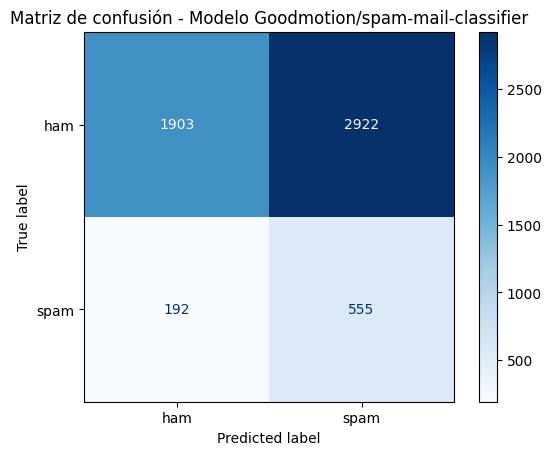

In [26]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ham", "spam"])
disp.plot(values_format="d", cmap="Blues")
plt.title("Matriz de confusión - Modelo Goodmotion/spam-mail-classifier")
plt.show()


In [27]:
try:
    auc = roc_auc_score(y_true, y_score)
    print(f"ROC-AUC: {auc:.4f}")
except Exception as e:
    print("No fue posible calcular AUC:", e)


ROC-AUC: 0.6229


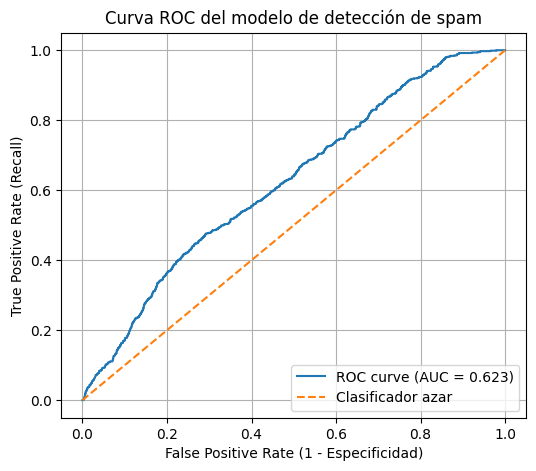

AUC-ROC: 0.6229


In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)

# Cálculo del AUC
roc_auc = roc_auc_score(y_true, y_score)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Clasificador azar")  # línea diagonal
plt.xlabel("False Positive Rate (1 - Especificidad)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Curva ROC del modelo de detección de spam")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC-ROC: {roc_auc:.4f}")

 <a id="con"></a>
## 5. Conclusiones
- En conclusión, el análisis de embeddings con PCA muestra que los mensajes SMS quedan organizados en un espacio latente con cierta estructura clara (la forma en “U”), pero la **separación visual entre spam y ham en solo dos dimensiones no es nítida**: los puntos de ambas clases aparecen bastante mezclados, con algunas zonas donde se concentra algo más el spam. Esto era esperable, porque PCA es una técnica no supervisada y solo estamos viendo una proyección 2D de un espacio de alta dimensión. Aun así, el ejercicio es útil para confirmar que el modelo genera una representación consistente del texto y que existen regiones del espacio donde el spam tiende a agruparse más, aunque la verdadera capacidad de separación del modelo se aprovecha mejor cuando trabaja en todo su espacio de embeddings y no solo en estas dos primeras componentes principales.

- Al evaluar el modelo `Goodmotion/spam-mail-classifier` sobre el dataset `SMSSpamCollection` obtenemos una **accuracy** global de 0.4411, lo que indica que, en promedio, solo acierta en torno al 44 % de los casos. Para la clase minoritaria `spam`, el modelo alcanza una **precision** muy baja de 0.1596 y un **recall** relativamente alto de 0.7430, con un **F1-score** de 0.2628. Esto significa que el modelo logra capturar alrededor del 74 % de los mensajes de spam reales (pocos falsos negativos), pero a costa de marcar como spam muchos mensajes que en realidad son `ham` (muchos falsos positivos), de ahí la baja precisión. En contraste, la clase `ham` tiene una precisión alta (0.91) pero un recall bajo (0.39), lo que refuerza la idea de que el modelo está “sobre-detectando” spam. El **AUC-ROC** obtenido (0.6229) sugiere que el modelo sí posee cierta capacidad de discriminación entre ambas clases, pero todavía lejos de un comportamiento óptimo. En conjunto, estos resultados indican que, en su configuración actual, el modelo no es suficientemente fiable para un escenario real sin realizar ajustes adicionales (por ejemplo, cambiar el umbral de decisión o considerar otros modelos/estrategias).
